In [1]:
import pandas as pd
import os
import torch
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from PIL import Image
import torch.optim as optim

torch.manual_seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/cs4243_smallest/
!ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1pCEBqzQDTJ3PlgdIRBY65jOugJ4xpFi6/cs4243_smallest
carrying  normal  threat


In [3]:
data_path = "/content/drive/My Drive/cs4243_smallest/"

# Data Preparation


In [4]:
data_df = pd.DataFrame(columns=['Image','Label'])
label_dict = {'normal':0,'carrying':1,'threat':2}
carrying = []
for filename in os.listdir(data_path+'normal'):
      data_df = data_df.append({'Image':'normal/'+filename,'Label':0}, ignore_index=True)
for filename in os.listdir(data_path+'carrying'):
      data_df = data_df.append({'Image':'carrying/'+filename,'Label':1}, ignore_index=True)
for filename in os.listdir(data_path+'threat'):
      data_df = data_df.append({'Image':'threat/'+filename,'Label':2}, ignore_index=True)
print(data_df)

                                                  Image Label
0     normal/A0161202B_20220814_normal_94580.57456_2...     0
1     normal/A0161202B_20220814_normal_94580.57456_1...     0
2     normal/A0170549Y_20220909_normal_32240.6373_30...     0
3     normal/A0170549Y_20220909_normal_32240.6373_10...     0
4     normal/A0170549Y_20220909_normal_32240.6373_20...     0
...                                                 ...   ...
4938  threat/0552261_20220904_threat_45670.27607_200...     2
4939  threat/0552261_20220904_threat_56780.34813_30.png     2
4940  threat/0552261_20220904_threat_56780.34813_100...     2
4941  threat/0552261_20220904_threat_67890.47122_30.png     2
4942  threat/0552261_20220904_threat_67890.47122_100...     2

[4943 rows x 2 columns]


In [5]:
traintestsplit = 0.82
train_df=data_df.sample(frac=traintestsplit,random_state=13) #random state is a seed value
test_df=data_df.drop(train_df.index)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

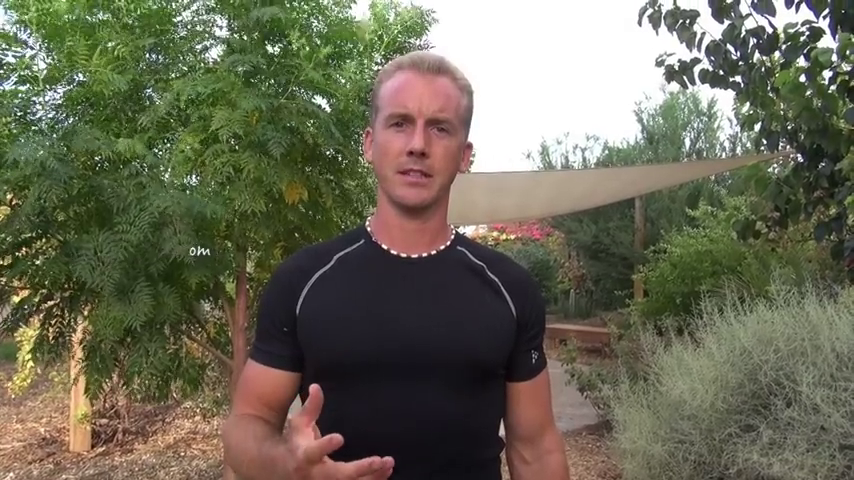

In [6]:
img_path = data_df.iloc[2]['Image']
img = Image.open(data_path + str(img_path)) 
img

# Dataloader


In [7]:
class dataset(Dataset): 
    
    def __init__(self, root_path , dataframe, transform=None):
        self.df = dataframe    
        self.transform = transform
        self.root_path = root_path
        self.image_paths = self.df['Image'] 
        self.labels = self.df['Label']
                
    def __getitem__(self, index):
        img_path = self.image_paths[index] 
        image = Image.open(self.root_path + str(img_path))
        target = torch.tensor(self.labels[index])
        if self.transform != None:
            image = self.transform(image)
        return image, target
        
    def __len__(self):
        return len(self.df)

In [8]:
class Network(nn.Module):
    def __init__(self, pretrained = True, num_classes = 3, drop_rate = 0.1):
        super(Network, self).__init__()
        resnet = models.resnet18(pretrained)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.dropout = nn.Dropout(p=drop_rate)
        fc_in_dim = list(resnet.children())[-1].in_features 
        self.fc = nn.Linear(fc_in_dim, num_classes) 

    def forward(self, x):
        x = self.features(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.softmax(x, dim=1)

# Base Model

In [9]:
def baseline_train(model,train_loader,optimizer,epoch,cuda):
  num_epochs = epoch
  criterion = nn.CrossEntropyLoss()
  num_correct = 0
  num_samples = 0
  batch = 0

  model.train() 
  print("Training Start")
  for epoch in range(num_epochs):
      for x, y in train_loader:
          if batch%10==0:
            print("Batch " + str(batch))
          batch+=1
          if cuda:
            x = x.to("cuda")
            y = y.to("cuda")

          preds = model(x) 
          loss = criterion(preds, y)
          optimizer.zero_grad() 
          loss.backward()
          optimizer.step() 
          num_correct += torch.sum(torch.eq(preds.argmax(1), y)).item()
          num_samples += preds.size(0)
      train_accuracy = num_correct/num_samples
      print(epoch, train_accuracy)
  path = F"/content/drive/My Drive/baseline.pt" 
  torch.save(model.state_dict(), path)
  print("Training End") 

# Modified Cross Entropy Loss (DEPRECATED)

In [10]:
def modified_loss(preds, targets):
  def log_softmax(x):
    return x - torch.logsumexp(x,dim=1, keepdim=True)
  num_examples = targets.shape[0]
  batch_size = preds.shape[0]
  outputs = log_softmax(preds)
  for x in range(len(outputs)):
    factor = (0.9+(1-preds[x,0].item())/10)
    outputs[x,1] = outputs[x,1]*factor
    outputs[x,2] = outputs[x,2]*factor
  outputs = outputs[range(batch_size), targets]
  return - torch.sum(outputs)/num_examples


def modified_train(model,train_loader,optimizer,epoch,cuda):
  num_epochs = epoch
  criterion = nn.CrossEntropyLoss()

  num_correct = 0
  num_samples = 0
  batch = 0
  model.train()
  print("Modified Training Start")
  torch.autograd.set_detect_anomaly(True)
  for epoch in range(num_epochs):
      for x, y in train_loader:
          if batch%10==0:
            print("Batch " + str(batch))
          batch+=1
          if cuda:
            x = x.to("cuda") 
            y = y.to("cuda") 

          preds = model(x) 
          loss = modified_loss(preds, y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step() 
          num_correct += torch.sum(torch.eq(preds.argmax(1), y)).item()
          num_samples += preds.size(0)
      train_accuracy = num_correct/num_samples
      print(epoch, train_accuracy)
  path = F"/content/drive/My Drive/modified.pt" 
  torch.save(model.state_dict(), path)
  print("Training End")  

In [11]:
def modified_argmax(preds,threshold):
  if preds[0][0]>threshold:
    return preds.argmax(1)
  elif preds[0][1]>preds[0][2]:
    return torch.LongTensor([1])
  else:
    return torch.LongTensor([2])


def test(model,test_loader,cuda,threshold):
  # confusion matrix
  matrix = [[0,0,0],[0,0,0],[0,0,0]]
  num_correct = 0
  num_samples = 0
  
  checkpoint_name = "baseline_15e.pt"
  path = F"/content/drive/My Drive/{checkpoint_name}"
  print(path)
  if cuda:
    model.load_state_dict(torch.load(path))
  else:
    model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))

  model.eval()
  print("Testing Start")
  with torch.no_grad():
    for x, y in test_loader:
      if cuda:
        x = x.to("cuda") 
        y = y.to("cuda") 

      preds = model(x) 
      if threshold == 0:
        preds_labels = preds.argmax(1)
      else:
        preds_labels = modified_argmax(preds,threshold)
      num_correct += torch.sum(torch.eq(preds_labels, y)).item()
      num_samples += preds.size(0)
      for idx in range(len(y)):
        matrix[preds_labels[idx]][y[idx]] += 1

      test_accuracy = num_correct/num_samples
    print(num_samples)
    print(test_accuracy)
    print(matrix)
    print("Testing End")

def modified_test(model,test_loader,cuda,threshold):
  # confusion matrix
  matrix = [[0,0,0],[0,0,0],[0,0,0]]
  num_correct = 0
  num_samples = 0
  
  checkpoint_name = "modified_15e.pt"
  path = F"/content/drive/My Drive/{checkpoint_name}"
  print(path)
  if cuda:
    model.load_state_dict(torch.load(path))
  else:
    model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))

  model.eval()
  print("Modified Testing Start")
  with torch.no_grad():
    for x, y in test_loader:
      if cuda:
        x = x.to("cuda") 
        y = y.to("cuda") 

      preds = model(x) 
      if threshold == 0:
        preds_labels = preds.argmax(1)
      else:
        preds_labels = modified_argmax(preds,threshold)
      num_correct += torch.sum(torch.eq(preds_labels, y)).item()
      num_samples += preds.size(0)
      for idx in range(len(y)):
        matrix[preds_labels[idx]][y[idx]] += 1
      test_accuracy = num_correct/num_samples
    print(num_samples)
    print(test_accuracy)
    print(matrix)
    print("Testing End")

# Main

In [12]:
epoch = 15
cuda = torch.cuda.is_available()
model = Network() 
if cuda:
  model.to("cuda")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
batch_size = 512
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transformations = transforms.Compose([
                transforms.Resize(size=(224,224),interpolation=2),
                transforms.ToTensor(), 
                normalize])

train_dataset = dataset(data_path, train_df, transform = transformations)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=2, shuffle = True, pin_memory=True)

test_dataset = dataset(data_path, test_df, transform = transformations)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, num_workers=1, shuffle = True, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [13]:
threshold = 0.9
#baseline_train(model,train_loader,optimizer,epoch,cuda)
#modified_train(model,train_loader,optimizer,epoch,cuda)
test(model,test_loader,cuda,threshold)
#modified_test(model,test_loader,cuda,threshold)
print("End")

/content/drive/My Drive/baseline_15e.pt
Testing Start
890
0.8123595505617978
[[248, 20, 16], [36, 226, 33], [27, 35, 249]]
Testing End
End
